**Set environment**

In [1]:
suppressMessages(suppressWarnings(source("../config/config_sing.R")))
show_env()

You are in Singularity: singularity_proj_encode_fcc 
BASE DIRECTORY (FD_BASE): /data/reddylab/Kuei 
WORK DIRECTORY (FD_WORK): /data/reddylab/Kuei/out 
CODE DIRECTORY (FD_CODE): /data/reddylab/Kuei/code 
PATH OF PROJECT (FD_PRJ): /data/reddylab/Kuei/code/Proj_CombEffect_ENCODE_FCC 
PATH OF RESULTS (FD_RES): /data/reddylab/Kuei/out/proj_combeffect_encode_fcc 
PATH OF LOG     (FD_LOG): /data/reddylab/Kuei/out/proj_combeffect_encode_fcc/log 


## Import data (All ATAC peaks)

In [4]:
fdiry = file.path(FD_RES, "results", "region", "KS91_K562_ASTARRseq_peak_macs_input")
fname = "KS91_K562_hg38_ASTARRseq_Input.all_reps.masked.union_narrowPeak.q5.bed.gz"
fpath = file.path(fdiry, fname)

cnames = c("Chrom", "Start", "End")
dat = read_tsv(fpath, col_names = cnames, show_col_types = FALSE)

dat_peak_atac_total = dat
print(dim(dat))
head(dat)

[1] 247520      3


Chrom,Start,End
<chr>,<dbl>,<dbl>
chr1,10015,10442
chr1,14253,14645
chr1,16015,16477
chr1,17237,17772
chr1,28903,29613
chr1,30803,31072


## Import data (FPKM)

In [5]:
ASSAY  = "KS91_K562_ASTARRseq"
FOLDER = "coverage_astarrseq_peak_macs_input"

fdiry = file.path(FD_RES, "results", ASSAY, FOLDER, "summary")
fname = "result.score.raw.cpm.WGS.tsv"
fpath = file.path(fdiry, fname)

dat = read_tsv(fpath)

dat_peak_coverage_astarr = dat
print(dim(dat))
head(dat)

Rows: 246852 Columns: 15
── Column specification ──────────────────────────────────────────────────────
Delimiter: "\t"
chr  (2): Chrom, Peak
dbl (13): Start, End, Length, Input, Output, Log2FC, pLog2FC, Input_Residual...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] 246852     15


Chrom,Start,End,Peak,Length,Input,Output,Log2FC,pLog2FC,Input_Residual,Input_Score,Output_Residual,Output_Score,Input_FPKM,Output_FPKM
<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr1,10015,10442,chr1:10015-10442,427,0.4863317,0.09736537,-2.3204599,-0.43771215,0.25149985,0.1362392,-0.1433799,0.07463616,1.1389501,0.2280219
chr1,14253,14645,chr1:14253-14645,392,0.3152472,0.27902967,-0.1760648,-0.04028420,0.19879784,0.1357280,0.1693269,0.07589325,0.8042019,0.7118104
chr1,16015,16477,chr1:16015-16477,462,0.4361424,0.15900628,-1.4557156,-0.30931046,0.08292808,0.1346040,-0.2127815,0.07435717,0.9440313,0.3441694
chr1,17237,17772,chr1:17237-17772,535,0.8007562,0.22194085,-1.8511878,-0.55942840,0.20062968,0.1357457,-0.4231641,0.07351143,1.4967405,0.4148427
chr1,28903,29613,chr1:28903-29613,710,0.7629703,0.16679463,-2.1935541,-0.59545755,-0.42906879,0.1296375,-1.1335228,0.07065579,1.0746061,0.2349220
chr1,30803,31072,chr1:30803-31072,269,0.2774187,0.21678565,-0.3557958,-0.07015643,0.57699942,0.1393966,0.5676036,0.07749432,1.0312963,0.8058946


## Define the active regions

In [6]:
### init
dat = dat_peak_atac_total

### how many peaks to pick for top 10%?
num = nrow(dat)
num = as.integer(num / 10)

### assign and show
num_size_top10 = num
print(dim(dat))
print(num)

[1] 247520      3
[1] 24752


In [7]:
### init
dat = dat_peak_coverage_astarr

### get the top 10%
dat = dat %>% 
    dplyr::select(Peak, Input_FPKM) %>% 
    dplyr::slice_max(order_by = Input_FPKM, n = num_size_top10)
vec = dat$Peak

### assign and show
vec_txt_peak_active = vec
print(dim(dat))
head(dat)

[1] 24752     2


Peak,Input_FPKM
<chr>,<dbl>
chr22:21735349-21736556,39.91072
chr13:91346980-91349411,39.42543
chr22:20916756-20918312,36.73703
chr22:21628337-21630433,33.80768
chr22:21641359-21643456,32.60726
chr22:20858084-20859511,31.77983


In [8]:
### init
dat = dat_peak_atac_total

### label peaks by top 10% of FPKM
dat = dat %>%
    dplyr::mutate(Peak = paste0(Chrom, ":", Start, "-", End)) %>% 
    dplyr::mutate(is_Top10 = Peak %in% vec_txt_peak_active) %>%
    dplyr::mutate(
        Assay_Type  = "ATAC",
        Assay_Label = ifelse(
            is_Top10,
            "ATAC_A",
            "ATAC_I"
        )
    )

### arrange table
dat = dat %>% 
    dplyr::select(Chrom, Start, End, Peak, Assay_Type, Assay_Label) %>%
    dplyr::arrange(Chrom, Start, End)

### combine with total
tmp = dat_peak_atac_total
tmp = tmp %>%
    dplyr::mutate(Peak = paste0(Chrom, ":", Start, "-", End)) %>%
    dplyr::mutate(
        Assay_Type  = "ATAC",
        Assay_Label = "ATAC_T")

dat = bind_rows(dat, tmp)

### assign and show
dat_peak_atac_label = dat
print(dim(dat))
head(dat)

[1] 495040      6


Chrom,Start,End,Peak,Assay_Type,Assay_Label
<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>
chr1,10015,10442,chr1:10015-10442,ATAC,ATAC_I
chr1,14253,14645,chr1:14253-14645,ATAC,ATAC_I
chr1,16015,16477,chr1:16015-16477,ATAC,ATAC_I
chr1,17237,17772,chr1:17237-17772,ATAC,ATAC_I
chr1,28903,29613,chr1:28903-29613,ATAC,ATAC_I
chr1,30803,31072,chr1:30803-31072,ATAC,ATAC_I


**Results**

In [9]:
dat = dat_peak_atac_label
table(dat$Assay_Label)


ATAC_A ATAC_I ATAC_T 
 24752 222768 247520 

## Explore the coverage distribution

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
 0.00072  0.64631  0.79845  1.46249  1.22433 39.91072 


Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 7 rows containing missing values (`geom_bar()`).”


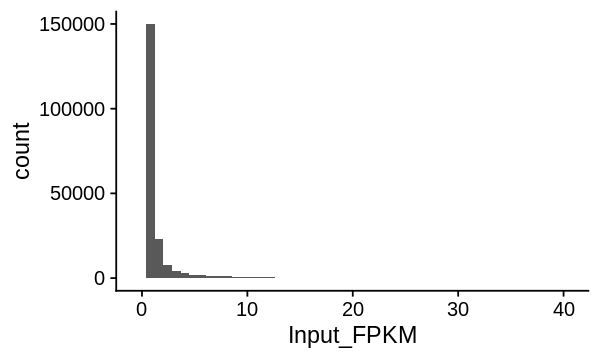

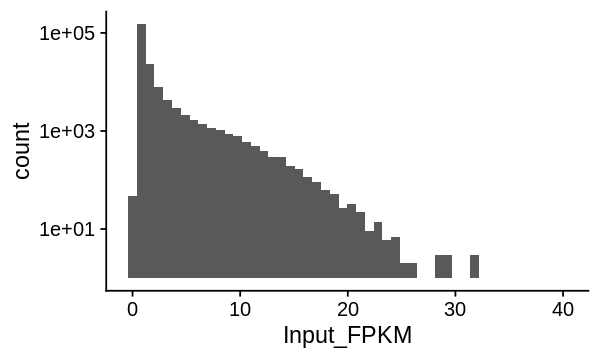

In [10]:
set.seed(123)
dat = dat_peak_coverage_astarr
dat = dat %>% dplyr::slice_sample(n=200000)
vec = dat$Input_FPKM
print(summary(vec))

options(repr.plot.height=3, repr.plot.width=5)
gpt = ggplot(dat, aes(x=Input_FPKM)) + 
    geom_histogram(bins=50) + 
    theme_cowplot()
print(gpt)

options(repr.plot.height=3, repr.plot.width=5)
gpt = ggplot(dat, aes(x=Input_FPKM)) + 
    geom_histogram(bins=50) + 
    scale_y_log10() +
    theme_cowplot()
print(gpt)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  2.709   3.600   5.200   6.356   8.103  39.911 


Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 6 rows containing missing values (`geom_bar()`).”


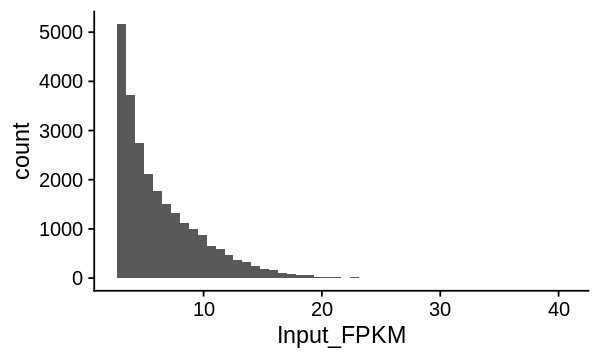

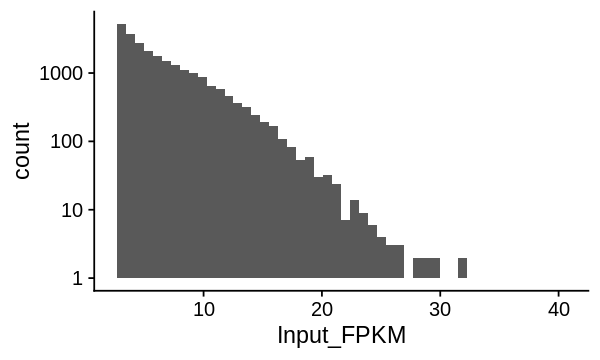

In [11]:
dat = dat_peak_coverage_astarr

dat = dat %>% dplyr::filter(Peak %in% vec_txt_peak_active)
vec = dat$Input_FPKM
print(summary(vec))

options(repr.plot.height=3, repr.plot.width=5)
gpt = ggplot(dat, aes(x=Input_FPKM)) + 
    geom_histogram(bins=50) + 
    theme_cowplot()
print(gpt)

options(repr.plot.height=3, repr.plot.width=5)
gpt = ggplot(dat, aes(x=Input_FPKM)) + 
    geom_histogram(bins=50) + 
    scale_y_log10() +
    theme_cowplot()
print(gpt)